В этом ноутбке исследуется применение статистики **Mutual Information** для отбора признаков из нашего датасета. 
Часть кода позаимствовал [отсюда](https://www.kaggle.com/code/pabangiri/feature-selection-using-mutual-information/notebook)

In [75]:
import sys
import os
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).resolve().parent))

import pandas as pd 
pd.set_option('display.max_columns', 150)

%load_ext autoreload
%autoreload 1
%aimport project.utils.data
%aimport project.utils.metrics

import numpy as np
from project.utils.data import *

from sktime.forecasting.all import temporal_train_test_split

from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectPercentile

import matplotlib.pyplot as plt

In [20]:
df = create_target_features(load_extended_data(), 'balance')

In [22]:
# df

In [23]:
# creating lag features
X = (
    df.drop(columns=['balance', 'income', 'outcome', 'income - outcome'])
)

# cutting nulls after creating lags 
start = X[X.isnull().sum(axis=1) == 0].index.min()

y, X = df['balance'][start:], X[start:]

assert y.shape[0] == X.shape[0], 'alarm (shape)'
assert y.index.min() == X.index.min(), 'alarm (dates)'

In [24]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.1)
cbr_rate_train, cbr_rate_test = df.key_rate[y_train.index], df.key_rate[y_test.index]

In [84]:
# determine the mutual information
mutual_info = mutual_info_regression(X_train.fillna(0), y_train)

In [85]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False).head(2)

non_working_day    0.547757
balance_max_7      0.443124
dtype: float64

Данных у нас немного, а если еще "отрезать" хвосты прошлого в случае разладок, то и того меньше, поэтому и признаки будем отбирать только потенциально самые полезные


In [86]:
NUM_FEATURES = 20

In [90]:
by_train = list(mutual_info.sort_values(ascending=False).head(20).index)

In [92]:
X_train[by_train].head(2)

,non_working_day,balance_max_7,non_working_day_usd,balance_min_7,L7_balance,balance_median_7,Sunday,balance_std_7,balance_mean_7,Saturday,mosprime_rub_1w,mosprime_rub_3m,mosprime_rub_1m,L1_balance,mosprime_rub_on,usd_xr,mosprime_rub_2w,mosprime_rub_6m,Monday,Wednesday
date,,,,,,,,,,,,,,,,,,,,
2017-01-22,1,0.057996,1,-0.548519,0.000000,-0.005391,1,0.206446,-0.104945,0,10.46,10.5,10.46,0.0,10.30,59.6697,10.49,10.5,0,0
2017-01-23,0,0.000000,0,-0.548519,0.057996,-0.109346,0,0.193730,-0.128851,0,10.43,10.5,10.46,0.0,10.23,59.6697,10.44,10.5,1,0


In [97]:
## Selecting the top 20 percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=40)
selected_top_columns.fit(X_train.fillna(0), y_train)

SelectPercentile(percentile=40,
                 score_func=<function mutual_info_regression at 0x16842d510>)

In [30]:
X_train.columns[selected_top_columns.get_support()]

Index(['non_working_day', 'non_working_day_usd', 'mosprime_rub_3m', 'Saturday',
       'Sunday', 'balance_mean_7', 'balance_std_7', 'balance_min_7',
       'balance_max_7', 'balance_median_7', 'L7_balance'],
      dtype='object')

Минутка экономической интуиции: 

Как можно понимать стабильность FS? Как будто имеет смысл посмотреть насколько пересекаются множества признаков во времени

Попробуем посэмплить данные из выборки и смотреть какая доля из признаков, отобранных на всем датасете собирается на этом кусочке данных

In [55]:
def select_topN_mutual_info(y, X, N=20):

    # determine the mutual information
    mutual_info = mutual_info_regression(X.fillna(0), y)
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = X.columns
    return list(mutual_info.sort_values(ascending=False).head(20).index)
    

In [59]:
by_all_data = select_topN_mutual_info(y, X)

In [93]:
bootstrap_res = []
N_sample = 300

for _ in range(100):
    bootstrap_idx = list(np.random.choice(X.index, N_sample, True))
    bootstrap_res.append(
        set(
            select_topN_mutual_info(y.loc[bootstrap_idx], X.loc[bootstrap_idx])
        )
    )

In [73]:
shares = [
    len(set(by_all_data).intersection(i)) / len(by_all_data) for i in bootstrap_res
]

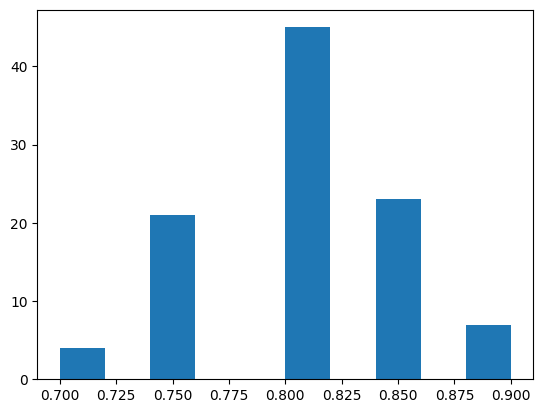

In [100]:
plt.hist(shares, bins=10);

In [95]:
np.mean(shares), np.std(shares)

(0.8039999999999999, 0.046733285782191686)

Считаю, что для сэмплов меньше 20% выборки еще и с повторами, результаты более, чем стабильные 

Можем добавлять в пайплайн и не бояться, что от нового наблюдения весь FS поплывет